# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni



**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface




# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:



Teaching Assistants:



- Federico Ruggeri -> federico.ruggeri6@unibo.it

- Eleonora Mancini -> e.mancini@unibo.it



Professor:

- Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition

The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).



### Examples:



**Text**: *Can’t go a day without women womening*



**Label**: Sexist



**Text**: *''Society's set norms! Happy men's day though!#weareequal''*



**Label**: Not sexist

In [1]:
!pip install evaluate
!mkdir -p ./data
!wget https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/72c93981fe38020285a16e1558d5d4a314bb1b82/2024-2025/Assignment%201/data/test.json -O data/test.json
!wget https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/72c93981fe38020285a16e1558d5d4a314bb1b82/2024-2025/Assignment%201/data/training.json -O data/training.json
!wget https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/72c93981fe38020285a16e1558d5d4a314bb1b82/2024-2025/Assignment%201/data/validation.json -O data/validation.json
!wget https://zenodo.org/record/3234051/files/embeddings-m-model.vec?download=1 -O spanish_embed.vec
!python -m spacy download es_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
--2025-01-12 09:34:25--  https://raw.githubusercontent.com/nlp-unibo/nlp-course-mate

In [2]:
import pandas as pd
import numpy as np
import gensim
import gensim.downloader as gloader
import tensorflow as tf
import re
import nltk
import keras
import evaluate
import spacy
import random
import matplotlib.pyplot as plt
from datasets import Dataset
from keras import Input
from keras.layers import Bidirectional, LSTM, Dense, Embedding
from keras.callbacks import Callback, ModelCheckpoint
from keras.optimizers import Nadam
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, OrderedDict
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
from transformers import AutoModelForSequenceClassification, TrainingArguments, AutoTokenizer, DataCollatorWithPadding, Trainer

#### Set an initial seed for reproducibility

In [3]:
seed = 42
np.random.seed(seed)
random.seed(seed)

# [Task 1 - 1.0 points] Corpus



We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).



Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.



The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.




### Dataset Description

- The dataset contains tweets in both English and Spanish.

- There are labels for multiple tasks, but we are focusing on **Task 1**.

- For Task 1, soft labels are assigned by six annotators.

- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").












### Example





    "203260": {

        "id_EXIST": "203260",

        "lang": "en",

        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",

        "number_annotators": 6,

        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],

        "gender_annotators": ["F", "F", "M", "M", "M", "F"],

        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],

        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],

        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],

        "labels_task3": [

          ["STEREOTYPING-DOMINANCE"],

          ["OBJECTIFICATION"],

          ["SEXUAL-VIOLENCE"],

          ["-"],

          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],

          ["OBJECTIFICATION"]

        ],

        "split": "TRAIN_EN"

      }

    }

### Instructions

1. **Download** the `A1/data` folder.

2. **Load** the three JSON files and encode them as pandas dataframes.

3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.

4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.

5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.

6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

---

1. **Download** the `A1/data` folder.

2. **Load** the three JSON files and encode them as pandas dataframes.

In [4]:
df_train = pd.read_json("./data/training.json").transpose().set_index("id_EXIST")
df_test = pd.read_json("./data/test.json").transpose().set_index("id_EXIST")
df_val = pd.read_json("./data/validation.json").transpose().set_index("id_EXIST")

In [5]:
df_train.head()

,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
id_EXIST,,,,,,,,,,
100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [6]:
print("- Training dataset shape:", df_train.shape)
print("- Test dataset shape:", df_test.shape)
print("- Validation dataset shape:", df_val.shape)

- Training dataset shape: (6920, 10)
- Test dataset shape: (312, 10)
- Validation dataset shape: (726, 10)


3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.

In [7]:
df_train_cp = df_train.copy()
df_test_cp = df_test.copy()
df_val_cp = df_val.copy()

# For each row of the datasets, using df.apply(), this sets the values for the new "hard_labels_task1" column.

df_train_cp['hard_labels_task1'] = df_train_cp['labels_task1'].apply(
    lambda x: 'YES' if x.count('YES') > x.count('NO') else ('NO' if x.count('NO') > x.count('YES') else np.NAN)
)

df_test_cp['hard_labels_task1'] = df_test_cp['labels_task1'].apply(
    lambda x: 'YES' if x.count('YES') > x.count('NO') else ('NO' if x.count('NO') > x.count('YES') else np.NAN)
)

df_val_cp['hard_labels_task1'] = df_val_cp['labels_task1'].apply(
    lambda x: 'YES' if x.count('YES') > x.count('NO') else ('NO' if x.count('NO') > x.count('YES') else np.NAN)
)


# Since for those rows without a clear majority vote the "hard_labels_task1" column was set to "NaN",
# this removes all those rows with the "NaN" value using df.dropna().

df_train_cp.dropna(inplace=True)
df_test_cp.dropna(inplace=True)
df_val_cp.dropna(inplace=True)

4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.

   **Expansion:** it has been decided to explore also spanish tweets, with the same preprocessing as the english text.

In [8]:
# English tweets
df_train_T1 = df_train_cp[df_train_cp["lang"] == "en"]
df_test_T1 = df_test_cp[df_test_cp["lang"] == "en"]
df_val_T1 = df_val_cp[df_val_cp["lang"] == "en"]

# Spanish tweets
df_train_es = df_train_cp[df_train_cp["lang"] == "es"]
df_test_es = df_test_cp[df_test_cp["lang"] == "es"]
df_val_es = df_val_cp[df_val_cp["lang"] == "es"]

5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.

In [9]:
# English tweets
df_train_T1 = df_train_T1.drop(
    ["number_annotators", "annotators","gender_annotators","age_annotators","labels_task1","labels_task2","labels_task3","split"],
    axis=1
)
df_test_T1 = df_test_T1.drop(
    ["number_annotators", "annotators","gender_annotators","age_annotators","labels_task1","labels_task2","labels_task3","split"],
    axis=1
)
df_val_T1 = df_val_T1.drop(
    ["number_annotators", "annotators","gender_annotators","age_annotators","labels_task1","labels_task2","labels_task3","split"],
    axis=1
)

# Spanish tweets
df_train_es = df_train_es.drop(
    ["number_annotators", "annotators","gender_annotators","age_annotators","labels_task1","labels_task2","labels_task3","split"],
    axis=1
)
df_test_es = df_test_es.drop(
    ["number_annotators", "annotators","gender_annotators","age_annotators","labels_task1","labels_task2","labels_task3","split"],
    axis=1
)
df_val_es = df_val_es.drop(
    ["number_annotators", "annotators","gender_annotators","age_annotators","labels_task1","labels_task2","labels_task3","split"],
    axis=1
)

6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [10]:
df_train_T1['hard_labels_task1'] = df_train_T1['hard_labels_task1'].apply(lambda x: 1 if x == 'YES' else 0)
df_test_T1['hard_labels_task1'] = df_test_T1['hard_labels_task1'].apply(lambda x: 1 if x == 'YES' else 0)
df_val_T1['hard_labels_task1'] = df_val_T1['hard_labels_task1'].apply(lambda x: 1 if x == 'YES' else 0)


df_train_es['hard_labels_task1'] = df_train_es['hard_labels_task1'].apply(lambda x: 1 if x == 'YES' else 0)
df_test_es['hard_labels_task1'] = df_test_es['hard_labels_task1'].apply(lambda x: 1 if x == 'YES' else 0)
df_val_es['hard_labels_task1'] = df_val_es['hard_labels_task1'].apply(lambda x: 1 if x == 'YES' else 0)

#### Visualisation

In [11]:
df_train_T1.head()

,lang,tweet,hard_labels_task1
id_EXIST,,,
200002,en,Writing a uni essay in my local pub with a cof...,1
200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,en,According to a customer I have plenty of time ...,1
200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,en,New to the shelves this week - looking forward...,0


In [12]:
print("English tweets \n")
print("- Training dataset shape:", df_train_T1.shape)
print("- Test dataset shape:", df_test_T1.shape)
print("- Validation dataset shape:", df_val_T1.shape)

English tweets 

- Training dataset shape: (2870, 3)
- Test dataset shape: (286, 3)
- Validation dataset shape: (158, 3)


In [13]:
df_train_es.head()

,lang,tweet,hard_labels_task1
id_EXIST,,,
100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",1
100002,es,@ultimonomada_ Si comicsgate se parece en algo...,0
100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",0
100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,1
100006,es,@yonkykong Aaah sí. Andrew Dobson. El que se d...,0


In [14]:
print("Spanish tweets \n")
print("- Training dataset shape:", df_train_es.shape)
print("- Test dataset shape:", df_test_es.shape)
print("- Validation dataset shape:", df_val_es.shape)

Spanish tweets 

- Training dataset shape: (3194, 3)
- Test dataset shape: (0, 3)
- Validation dataset shape: (490, 3)


As we can see from the previous output, **in the test set there are no spanish tweets**. Therefore, for the further computations and evaluations the validation set is used to test the models and the comparisons between the two languages are done by taking into consideration the corresponding validation sets.

# [Task2 - 0.5 points] Data Cleaning

In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.




### Instructions

- **Remove emojis** from the tweets.

- **Remove hashtags** (e.g., `#example`).

- **Remove mentions** such as `@user`.

- **Remove URLs** from the tweets.

- **Remove special characters and symbols**.

- **Remove specific quote characters** (e.g., curly quotes).

- **Perform lemmatization** to reduce words to their base form.

---

The same cleaning procedure is applied on both the languages. In particular, for Spanish tweets an ad hoc lemmatization is applied, taken from the [**spaCy library**](https://spacy.io/models/es), where there are specific models to deal with different languages. The model used in this particular case is the `es_core_news_sm`, which is a Spanish language model trained on the *Universal Dependencies (UD) Spanish AnCora* corpus. This is the small version, since there is also the medium (`md`) and the large one (`lg`), but it has been preferred to the others because the behavioural differences are very small, it is lighter and remains still an efficient and affordable model.

In [15]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()
tagger_es = spacy.load("es_core_news_sm")

# This attempts to import a set of English and Spanish stopwords
try:
    STOPWORDS_EN = set(stopwords.words('english'))
    STOPWORDS_ES = set(stopwords.words('spanish'))

# If the stopwords resource is not found, it is dowloaded.
except LookupError:
    nltk.download('stopwords')
    STOPWORDS_EN = set(stopwords.words('english'))
    STOPWORDS_ES = set(stopwords.words('spanish'))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
# This function maps POS tags to WordNet POS tag
# This is needed for using the WordNetLemmatizer()
def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ

    elif pos_tag.startswith('V'):
        return wordnet.VERB

    elif pos_tag.startswith('N'):
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV

    else:
        return wordnet.NOUN



# This function lemmatizes text using WordNet POS tagging
def lem_text(text, lang='english'):
    if lang=='english':
        tokens = word_tokenize(text, language=lang)
        tagged = pos_tag(tokens)
        words = [lemmatizer.lemmatize(token, get_wordnet_key(tag)) for token, tag in tagged]
    elif lang=='spanish':
        tagged = tagger_es(text)
        words = [token.lemma_ for token in tagged]
    return " ".join(words)


# To remove emojis
def strip_emoji(text):
    RE_EMOJI = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    return RE_EMOJI.sub(r'', text)


# To remove mentions, hashtags and punctuations.
def strip_tags(text):
    entity_prefixes = ['@','#']
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                if entity_prefixes[0] in word:
                    idx = word.find(entity_prefixes[0])
                    words.append(word[:idx])
                elif entity_prefixes[1] in word:
                    idx = word.find(entity_prefixes[1])
                    words.append(word[:idx])
                else:
                    words.append(word)
    return ' '.join(words)


# To remove all links (URLs)
def remove_links(text):
    # Regular expression pattern to match URLs
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)


# To remove special characters and symbols
def special_ch_sym(text):
    RE_ch_sym = re.compile(u'[^a-z A-Z 0-9 À-ú]')
    return RE_ch_sym.sub(r' ',text)


# To remove "br" characters
def replace_br(text):
    return text.replace('<br>', ' ')


# To remove stopwords
def remove_stopwords(text, stopwords):
    return ' '.join([x for x in text.split() if x and x not in stopwords])


# All the functions are then applied to the text
def text_cleaning_en(text):
    return lem_text(remove_stopwords(replace_br(special_ch_sym(strip_tags(remove_links(strip_emoji(text.lower().strip()))))), STOPWORDS_EN), 'english')

def text_cleaning_es(text):
    return lem_text(remove_stopwords(replace_br(special_ch_sym(strip_tags(remove_links(strip_emoji(text.lower().strip()))))), STOPWORDS_ES), 'spanish')

In [17]:
# df_train_T1 -> It contains the original tweets
# df_train_T2 -> It contains the cleaned tweets

df_train_T2 = df_train_T1.copy()
df_train_T2['tweet'] = df_train_T2['tweet'].apply(text_cleaning_en)

df_test_T2 = df_test_T1.copy()
df_test_T2['tweet'] = df_test_T2['tweet'].apply(text_cleaning_en)

df_val_T2 = df_val_T1.copy()
df_val_T2['tweet'] = df_val_T2['tweet'].apply(text_cleaning_en)

df_train_T2.head()

,lang,tweet,hard_labels_task1
id_EXIST,,,
200002,en,write uni essay local pub coffee random old ma...,1
200003,en,2021 1921 dont appreciate two ride team member...,1
200006,en,accord customer plenty time go spent stirling ...,1
200007,en,bloke drink beer sorry bloke drink wine appare...,1
200008,en,new shelf week look forward read book,0


In [18]:
df_train_clean_es = df_train_es.copy()
df_train_clean_es['tweet'] = df_train_clean_es['tweet'].apply(text_cleaning_es)

df_val_clean_es = df_val_es.copy()
df_val_clean_es['tweet'] = df_val_clean_es['tweet'].apply(text_cleaning_es)

df_train_clean_es.head()

,lang,tweet,hard_labels_task1
id_EXIST,,,
100001,es,ignorar capullo problema youtuber denunciar ac...,1
100002,es,si comicsgate parecer gamergate pues bien acos...,0
100003,es,leer gamergate cambiado manera comunicar inter...,0
100005,es,entonces así mercado mejor hacer cambiar él se...,1
100006,es,aaah andrew dobson dedicar echar mierdo gamerg...,0


# [Task 3 - 0.5 points] Text Encoding

To train a neural sexism classifier, you first need to encode text into numerical format.






### Instructions



* Embed words using **GloVe embeddings**.

* You are **free** to pick any embedding dimension.








### Note : What about OOV tokens?

   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.

   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.

   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)




### More about OOV



For a given token:



* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).

* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.



Your vocabulary **should**:



* Contain all tokens in train set; or

* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

---

1. **Building a vocabulary**

In [19]:
def build_vocabulary(df, lang='english'):
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 0

    # "<pad>" it the first element of the dictionary
    word_to_idx['<pad>'] = curr_idx
    idx_to_word[curr_idx] = '<pad>'
    curr_idx += 1

    for sentence in df.tweet.values:
        tokens = word_tokenize(sentence, language=lang)
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    # "<unk>" it the last element of the dictionary
    word_to_idx['<unk>'] = curr_idx
    idx_to_word[curr_idx] = '<unk>'

    word_listing = list(idx_to_word.values())

    return idx_to_word, word_to_idx, word_listing

In [20]:
idx_to_word_en, word_to_idx_en, word_listing_en = build_vocabulary(df_train_T2)
vocab_size_en = len(idx_to_word_en)

print('English Vocabulary\n')
print(f'Index -> Word vocabulary size: {len(idx_to_word_en)}')
print(f'Word -> Index vocabulary size: {len(word_to_idx_en)}')
print(f'Some words: {[(idx_to_word_en[idx], idx) for idx in np.arange(0, 10)]}')

English Vocabulary

Index -> Word vocabulary size: 9009
Word -> Index vocabulary size: 9009
Some words: [('<pad>', 0), ('write', 1), ('uni', 2), ('essay', 3), ('local', 4), ('pub', 5), ('coffee', 6), ('random', 7), ('old', 8), ('man', 9)]


In [21]:
idx_to_word_es, word_to_idx_es, word_listing_es = build_vocabulary(df_train_clean_es, 'spanish')
vocab_size_es = len(idx_to_word_es)

print('Spanish Vocabulary \n')
print(f'Index -> Word vocabulary size: {len(idx_to_word_es)}')
print(f'Word -> Index vocabulary size: {len(word_to_idx_es)}')
print(f'Some words: {[(idx_to_word_es[idx], idx) for idx in np.arange(0, 10)]}')

Spanish Vocabulary 

Index -> Word vocabulary size: 11587
Word -> Index vocabulary size: 11587
Some words: [('<pad>', 0), ('ignorar', 1), ('capullo', 2), ('problema', 3), ('youtuber', 4), ('denunciar', 5), ('acoso', 6), ('afectar', 7), ('gente', 8), ('izquierdo', 9)]


In [22]:
def evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df, check_default_size: bool = False):

    print("  [Vocabulary Evaluation] Size checking...")
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    print("  [Vocabulary Evaluation] Content checking...")
    for i in range(0, len(idx_to_word)):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    print("  [Vocabulary Evaluation] Consistency checking...")
    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

In [23]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word_en, word_to_idx_en, word_listing_en, df_train_T2)
print("\nEvaluation completed!")

Vocabulary evaluation...
  [Vocabulary Evaluation] Size checking...
  [Vocabulary Evaluation] Content checking...
  [Vocabulary Evaluation] Consistency checking...

Evaluation completed!


In [24]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word_es, word_to_idx_es, word_listing_es, df_train_clean_es)
print("\nEvaluation completed!")

Vocabulary evaluation...
  [Vocabulary Evaluation] Size checking...
  [Vocabulary Evaluation] Content checking...
  [Vocabulary Evaluation] Consistency checking...

Evaluation completed!


2. **Embedding**

For the English tweets the choice has been a GloVe embedding model in the `gensim` library that is already trained on **Twitter** [*(glove-twitter-100)*](https://github.com/piskvorky/gensim-data). On the other hand, the availability of models for Spanish is not as big as English, even if there are a lot of valuable alternatives. The choice in this case has been a FastText embedding model, with embedding dimension 100, trained on the **Spanish Unannotated Corpora (SUC)** [*(spanish-word-embeddings)*](https://github.com/dccuchile/spanish-word-embeddings/blob/master/emb-from-suc.md).

In [25]:
embedding_dimension = 100
glove_model = gloader.load("glove-twitter-{}".format(embedding_dimension))
spanish_model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format("spanish_embed.vec")

[==================================================] 100.0% 387.1/387.1MB downloaded


3. **Out of vocabulary (OOV) words**

In [26]:
# This returns a list of all those in the training set that are not in GloVe
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing):

    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)

    return list(oov)

In [27]:
oov_terms_glove = check_OOV_terms(glove_model, word_listing_en)
oov_percentage_glove = float(len(oov_terms_glove)) * 100 / len(word_listing_en)

print(f"OOV terms (English GloVe): {len(oov_terms_glove)} ({oov_percentage_glove:.2f}%)")

OOV terms (English GloVe): 1046 (11.61%)


In [28]:
oov_terms_es = check_OOV_terms(spanish_model, word_listing_es)
oov_percentage_es = float(len(oov_terms_es)) * 100 / len(word_listing_es)

print(f"OOV terms (Spanish FastText): {len(oov_terms_es)} ({oov_percentage_es:.2f}%)")

OOV terms (Spanish FastText): 1633 (14.09%)


4. **Building the Embedding Matrix**

The OOV terms management is the same for both embedding matrices, even if the two models behave differently in practice, in order to provide a performance comparison on the most equal working conditions possible.

In [29]:
def build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, vocab_size):

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():

        # For each word in the training set, an embedding vector is created by GloVe
        try:
            embedding_vector = embedding_model[word]

        # If the word is not present, it must be added
        except (KeyError, TypeError):
            if word == "<unk>":
                # To "<unk>" a vector of all zeros is set
                embedding_vector = np.zeros(embedding_dimension)

            else:
                # To all the other words a random vector is set
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

An **embedding matrix** is built for each of the embedding model used, starting from the *English* and *Spanish vocabulary* previously defined.

In [30]:
embed_matrix_glove = build_embedding_matrix(glove_model,
                                          embedding_dimension,
                                          word_to_idx_en,
                                          vocab_size_en)

print(f"Embedding matrix shape (English): {embed_matrix_glove.shape}")

Embedding matrix shape (English): (9009, 100)


In [31]:
embed_matrix_spanish = build_embedding_matrix(spanish_model,
                                              embedding_dimension,
                                              word_to_idx_es,
                                              vocab_size_es)

print(f"Embedding matrix shape (Spanish): {embed_matrix_spanish.shape}")

Embedding matrix shape (Spanish): (11587, 100)


## References:

- Bojanowski, Piotr, et al. "Enriching word vectors with subword information." *Transactions of the association for computational linguistics* 5 (2017): 135-146.

# [Task 4 - 1.0 points] Model definition



You are now tasked to define your sexism classifier.






### Instructions



* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.

* You are **free** to experiment with hyper-parameters to define the baseline model.



* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping



You can follow two approaches for encoding tokens in your classifier.



### Work directly with embeddings



- Compute the embedding of each input token

- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model



### Work with Embedding layer



- Encode input tokens to token ids

- Define a Embedding layer as the first layer of your model

- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)

- Initialize the Embedding layer with the computed embedding matrix

- You are **free** to set the Embedding layer trainable or not

### Padding



Pay attention to padding tokens!



Your model **should not** be penalized on those tokens.



#### How to?



There are two main ways.



However, their implementation depends on the neural library you are using.



- Embedding layer

- Custom loss to compute average cross-entropy on non-padding tokens only



**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

---

It has been decided to pick the hyperparameters for the training according to the paper [_**"A comprehensive study of deep bidirectional LSTM RNNs for acoustic modeling in speech recognition."**_](https://arxiv.org/abs/1606.06871), which explores different solutions. The right adaptation for this task has been using a `NAdam` optimizer, with 0.9 of momentum, which combines the *adaptability of the Adam optimizer* with the *Nesterov Accelerated Gradient (NAG)*, which adjusts the direction of the gradient before it is applied.

In [32]:
# ----- Hyperparameters ----- #

hidden_dim = 64
num_classes = 2
max_len_en = max(df_train_T2['tweet'].apply(lambda x: len(word_tokenize(x))))
max_len_es = max(df_train_es['tweet'].apply(lambda x: len(word_tokenize(x, language='spanish'))))
seeds = [42, 132, 1337]
batch_size = 16
epochs = 10

In [33]:
@keras.saving.register_keras_serializable()

class Bidirectional_LSTM (tf.keras.Model):

    # input_dim: Lenght of the input tweets.
    # hidden_dim: Dimensionality of the hidden layers in the LSTMs.
    # num_layers: Number of stacked bidirectional LSTM layers. Default value is 1.
        # 1 --> Baseline LSTM
        # 2 --> Model 1 LSTM

    def __init__(self, input_dim, output_dim, hidden_dim, vocab_size, language="english", num_layers = 1, name=None, **kwargs):
        super(Bidirectional_LSTM, self).__init__(**kwargs)

        self.name = name
        self.language = language
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.vocab_size = vocab_size
        if language == 'english':
            self.embedding_matrix = embed_matrix_glove
        elif language == "spanish":
            self.embedding_matrix = embed_matrix_spanish

        # To map integer tokens to dense vectors
        self.embed_layer = Embedding(input_dim=self.vocab_size,
                                      output_dim=embedding_dimension,
                                      weights=[self.embedding_matrix],
                                      mask_zero=True,   # automatically masks padding tokens
                                      name='encoder_embedding')

        # First bidirectional LSTM layer - Baseline
        self.bidir_layer_1 = Bidirectional(LSTM(hidden_dim), backward_layer=LSTM(hidden_dim, go_backwards=True))
        self.bidir_layers_2 = []

        # Additional bidirectional LSTM layers - Model 1
        for i in range(num_layers-1):
            self.bidir_layers_2.append(Bidirectional(LSTM(hidden_dim, return_sequences=True),
                                                     backward_layer=LSTM(hidden_dim, go_backwards=True, return_sequences=True)))

        # Dense output layer
        self.dense_layer = Dense(output_dim, activation='softmax')



    def build(self):
        # Call the model with a random input to define its shape
        self.call(keras.random.normal((self.input_dim, 1)))
        self.built = True



    # Forward pass of the model
    def call(self, input):
        x = self.embed_layer(input)
        for idx, layer in enumerate(self.bidir_layers_2):
            x = layer(x)
        x = self.bidir_layer_1(x)
        output = self.dense_layer(x)
        return output



    #method for the serialization of the model
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim" : self.input_dim,
            "output_dim" : self.output_dim,
            "hidden_dim" : self.hidden_dim,
            "num_layers" : self.num_layers,
            "name" : self.name,
            "vocab_size" : self.vocab_size,
            "language" : self.language,
        })
        return config

#### Visualisation of the number of parameters (English model)

In [34]:
baseline_en = Bidirectional_LSTM(input_dim=max_len_en,
                                   output_dim=num_classes,
                                   hidden_dim=hidden_dim,
                                   vocab_size=vocab_size_en,
                                   language="english",
                                   num_layers=1,
                                   name="EN_Baseline_LSTM")
baseline_en.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
baseline_en.build()
baseline_en.summary()

Model: "EN_Baseline_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)        │ ?                           │         900,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (37, 128)                   │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (37, 2)                     │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 985,638 (3.76 MB)

 Trainable params: 985,638 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model_1_en = Bidirectional_LSTM(input_dim=max_len_en,
                                  output_dim=num_classes,
                                  hidden_dim=hidden_dim,
                                  vocab_size=vocab_size_en,
                                  language="english",
                                  num_layers=2,
                                  name="EN_Model_1_LSTM")
model_1_en.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model_1_en.build()
model_1_en.summary()

Model: "EN_Model_1_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)        │ ?                           │         900,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (37, 128)                   │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (37, 1, 128)                │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (37, 2)                     │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,084,454 (4.14 MB)

 Trainable params: 1,084,454 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

#### Visualisation of the number of parameters (Spanish model)

In [36]:
baseline_es = Bidirectional_LSTM(input_dim=max_len_es,
                                 output_dim=num_classes,
                                 hidden_dim=hidden_dim,
                                 vocab_size=vocab_size_es,
                                 language="spanish",
                                 num_layers=1,
                                 name="ES_Baseline_LSTM")
baseline_es.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
baseline_es.build()
baseline_es.summary()

Model: "ES_Baseline_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)        │ ?                           │       1,158,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (84, 128)                   │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (84, 2)                     │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,243,438 (4.74 MB)

 Trainable params: 1,243,438 (4.74 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model_1_es = Bidirectional_LSTM(input_dim=max_len_es,
                                output_dim=num_classes,
                                hidden_dim=hidden_dim,
                                vocab_size=vocab_size_es,
                                language="spanish",
                                num_layers=2,
                                name="ES_Model_1_LSTM")
model_1_es.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model_1_es.build()
model_1_es.summary()

Model: "ES_Model_1_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)        │ ?                           │       1,158,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (84, 128)                   │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (84, 1, 128)                │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (84, 2)                     │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,342,254 (5.12 MB)

 Trainable params: 1,342,254 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

## References:

* Zeyer, Albert, et al. "A comprehensive study of deep bidirectional LSTM RNNs for acoustic modeling in speech recognition." *2017 IEEE international conference on acoustics, speech and signal processing (ICASSP).* IEEE, 2017.

# [Task 5 - 1.0 points] Training and Evaluation



You are now tasked to train and evaluate the Baseline and Model 1.




### Instructions



* Train **all** models on the train set.

* Evaluate **all** models on the validation set.

* Compute metrics on the validation set.

* Pick **at least** three seeds for robust estimation.

* Pick the **best** performing model according to the observed validation set performance.

* Evaluate your models using macro F1-score.

---

## Training

Both the `Baseline LSTM` and the `Model 1 LSTM` models have been trained and evaluated using three different random seeds. For each English model, we have picked the best instance, with the related seed, which has been evaluated on the _test set_ for single model performances and overall performaces. On the other hand, the evaluaton of the Spanish model is made exclusively on the *validation set*.

In [38]:
# Callback to compute the F1 score at the end of each epoch.

class F1ScoreCallback(Callback):

    # it takes the DataGenerator for validation data
    def __init__(self, validation_generator):
        super(F1ScoreCallback, self).__init__()

        self.validation_generator = validation_generator


    def on_epoch_end(self, epoch, logs=None):
        # Accumulate predictions and true labels across all validation batches
        all_predictions = []
        all_true_labels = []

        for i in range(len(self.validation_generator)):

            # Fetch the next batch of validation data
            val_inputs, val_labels = self.validation_generator[i]

            # Predict on the batch
            batch_predictions = np.argmax(self.model.predict(val_inputs, verbose=0), axis=-1)
            val_labels = np.argmax(val_labels, axis=1)

            # Collect predictions and true labels
            all_predictions.append(batch_predictions)
            all_true_labels.append(val_labels)

        # Compute F1 score
        f1 = f1_score(all_true_labels, all_predictions, average='macro')

        # Log the F1 score
        logs['f1_score'] = f1

The models are fed with data coming from a `DataGenerator`, which converts them into a format that is suitable for the training process. In the case of the training set, it also shuffles the indices after each epoch to change the batch distribution.

In [39]:
class DataGenerator(Sequence):

    def __init__(self, data, word_to_idx, word_listing, max_len, lang='english', batch_size=16, shuffle=True, seed=seed):
        super().__init__()

        self.data = data
        self.tweet = data["tweet"].to_numpy()
        self.hard_labels_task1 = data["hard_labels_task1"]
        self.word_to_idx = word_to_idx
        self.word_listing = word_listing
        self.max_len = max_len
        self.lang = lang
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()
        self._prepare_data()



    # Number of batches in the dataset
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))



    # It returns a batch of data and its corresponding target labels
    def __getitem__(self, index):

        indexes = self.indexes[index*self.batch_size: (index+1)*self.batch_size]
        data_batch = np.array([self.tweet[k] for k in indexes])
        target_batch = np.array([[1, 0] if self.hard_labels_task1.to_list()[k]==0 else [0, 1] for k in indexes])

        return (data_batch, target_batch)



    # It resets data indexes for shuffling at the end of each epoch
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)



    # It preprocesses tweet data for model input.
    def _prepare_data(self):

        # Tweets are firstly tokenized, and then padding is applied to reach "max_len" length
        self.tweet = [word_tokenize(sentence, self.lang) + ['<pad>']*(self.max_len - len(word_tokenize(sentence, self.lang))) for sentence in self.tweet]

        # Words are converted to their corresponding indices using `word_to_idx`, and unknown words are replaced with the '<unk>' index.
        self.tweet = [[self.word_to_idx[word] if word in self.word_listing else self.word_to_idx["<unk>"] for word in sentence] for sentence in self.tweet]

### Trainings for English models

In [40]:
GL_baseline_f1_scores = []
GL_baseline_urls = []
GL_model_1_f1_scores = []
GL_model_1_urls = []

for seed in seeds:

    # Seed initialization
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Data generation
    train_gen = DataGenerator(df_train_T2, word_to_idx_en, word_listing_en, max_len_en, batch_size=batch_size, shuffle=True, seed=seed)
    validation_gen = DataGenerator(df_val_T2, word_to_idx_en, word_listing_en, max_len_en, batch_size=1, shuffle=False, seed=seed)



    # ----- BASELINE LSTM ----- #
    baseline_LSTM = Bidirectional_LSTM(input_dim=max_len_en,
                                       output_dim=num_classes,
                                       hidden_dim=hidden_dim,
                                       vocab_size=vocab_size_en,
                                       language="english",
                                       num_layers=1,
                                       name=f"EN_baseline_LSTM_{seed}")
    baseline_LSTM.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks definition
    f1_call = F1ScoreCallback(validation_gen)
    model_check = ModelCheckpoint(f'./English/baseline_instances/EN_baseline_{seed}.keras', monitor='f1_score', mode='max', verbose=0, save_best_only=True)

    # Training
    print(f'\nTraining model {baseline_LSTM.name}...')
    baseline_LSTM.fit(train_gen, validation_data=validation_gen, batch_size=batch_size, epochs=epochs, callbacks=[f1_call, model_check], verbose=0)
    GL_baseline_urls.append(f'./English/baseline_instances/EN_baseline_{seed}.keras')

    # F1 score computation on the validation set
    baseline_LSTM = keras.saving.load_model(f'./English/baseline_instances/EN_baseline_{seed}.keras')
    pred = baseline_LSTM.predict(validation_gen, verbose=0)
    f1 = f1_score(np.argmax(pred, axis=-1), df_val_T2['hard_labels_task1'].to_list())
    GL_baseline_f1_scores.append(f1)
    print('   [COMPLETE]')



    # ----- MODEL 1 LSTM ----- #
    model_1_LSTM = Bidirectional_LSTM(input_dim=max_len_en,
                                     output_dim=num_classes,
                                     hidden_dim=hidden_dim,
                                     vocab_size=vocab_size_en,
                                     language="english",
                                     num_layers=2,
                                     name=f"EN_model_1_{seed}")
    model_1_LSTM.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks definition
    f1_call = F1ScoreCallback(validation_gen)
    model_check = ModelCheckpoint(f'./English/model_1_instances/EN_model_1_{seed}.keras', monitor='f1_score', mode='max', verbose=0, save_best_only=True)

    # Training
    print(f'\nTraining model {model_1_LSTM.name}...')
    model_1_LSTM.fit(train_gen, validation_data=validation_gen, batch_size=batch_size, epochs=epochs, callbacks=[f1_call, model_check], verbose=0)
    GL_model_1_urls.append(f'./English/model_1_instances/EN_model_1_{seed}.keras')

    # F1 score computation on the validation set
    model_1_LSTM = keras.saving.load_model(f'./English/model_1_instances/EN_model_1_{seed}.keras')
    pred = model_1_LSTM.predict(validation_gen, verbose=0)
    f1 = f1_score(np.argmax(pred, axis=-1), df_val_T2['hard_labels_task1'].to_list())
    GL_model_1_f1_scores.append(f1)
    print('   [COMPLETE]')


Training model EN_baseline_LSTM_42...
   [COMPLETE]

Training model EN_model_1_42...
   [COMPLETE]

Training model EN_baseline_LSTM_132...
   [COMPLETE]

Training model EN_model_1_132...
   [COMPLETE]

Training model EN_baseline_LSTM_1337...
   [COMPLETE]

Training model EN_model_1_1337...
   [COMPLETE]


### Trainings for Spanish models

In [41]:
ES_baseline_f1_scores = []
ES_baseline_urls = []
ES_model_1_f1_scores = []
ES_model_1_urls = []

for seed in seeds:

    # Seed initialization
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Data generation
    train_gen = DataGenerator(df_train_clean_es, word_to_idx_es, word_listing_es, max_len_es, batch_size=batch_size, shuffle=True, seed=seed)
    validation_gen = DataGenerator(df_val_clean_es, word_to_idx_es, word_listing_es, max_len_es, batch_size=1, shuffle=False, seed=seed)



    # ----- BASELINE LSTM ----- #
    baseline_LSTM = Bidirectional_LSTM(input_dim=max_len_es,
                                       output_dim=num_classes,
                                       hidden_dim=hidden_dim,
                                       vocab_size=vocab_size_es,
                                       language="spanish",
                                       num_layers=1,
                                       name=f"ES_Baseline_LSTM_{seed}")
    baseline_LSTM.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks definition
    f1_call = F1ScoreCallback(validation_gen)
    model_check = ModelCheckpoint(f'./Spanish/baseline_instances/ES_baseline_{seed}.keras', monitor='f1_score', mode='max', verbose=0, save_best_only=True)

    # Training
    print(f'\nTraining model {baseline_LSTM.name}...')
    baseline_LSTM.fit(train_gen, validation_data=validation_gen, batch_size=batch_size, epochs=epochs, callbacks=[f1_call, model_check], verbose=0)
    ES_baseline_urls.append(f'./Spanish/baseline_instances/ES_baseline_{seed}.keras')

    # F1 score computation on the validation set
    baseline_LSTM = keras.saving.load_model(f'./Spanish/baseline_instances/ES_baseline_{seed}.keras')
    pred = baseline_LSTM.predict(validation_gen, verbose=0)
    f1 = f1_score(np.argmax(pred, axis=-1), df_val_clean_es['hard_labels_task1'].to_list())
    ES_baseline_f1_scores.append(f1)
    print('   [COMPLETE]')



    # ----- MODEL 1 LSTM ----- #
    model_1_LSTM = Bidirectional_LSTM(input_dim=max_len_es,
                                     output_dim=num_classes,
                                     hidden_dim=hidden_dim,
                                     vocab_size=vocab_size_es,
                                     language="spanish",
                                     num_layers=2,
                                     name=f"ES_Model_1_LSTM_{seed}")
    model_1_LSTM.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks definition
    f1_call = F1ScoreCallback(validation_gen)
    model_check = ModelCheckpoint(f'./Spanish/model_1_instances/ES_model_1_{seed}.keras', monitor='f1_score', mode='max', verbose=0, save_best_only=True)

    # Training
    print(f'\nTraining model {model_1_LSTM.name}...')
    model_1_LSTM.fit(train_gen, validation_data=validation_gen, batch_size=batch_size, epochs=epochs, callbacks=[f1_call, model_check], verbose=0)
    ES_model_1_urls.append(f'./Spanish/model_1_instances/ES_model_1_{seed}.keras')

    # F1 score computation on the validation set
    model_1_LSTM = keras.saving.load_model(f'./Spanish/model_1_instances/ES_model_1_{seed}.keras')
    pred = model_1_LSTM.predict(validation_gen, verbose=0)
    f1 = f1_score(np.argmax(pred, axis=-1), df_val_clean_es['hard_labels_task1'].to_list())
    ES_model_1_f1_scores.append(f1)
    print('   [COMPLETE]')


Training model ES_Baseline_LSTM_42...
   [COMPLETE]

Training model ES_Model_1_LSTM_42...
   [COMPLETE]

Training model ES_Baseline_LSTM_132...
   [COMPLETE]

Training model ES_Model_1_LSTM_132...
   [COMPLETE]

Training model ES_Baseline_LSTM_1337...
   [COMPLETE]

Training model ES_Model_1_LSTM_1337...
   [COMPLETE]


## Evaluation

### Baseline performances evaluation (English)

In [42]:
average = np.average(GL_baseline_f1_scores)
std = np.std(GL_baseline_f1_scores)

idx_base = np.argmax(GL_baseline_f1_scores)
best_f1_base = GL_baseline_f1_scores[idx_base]
best_url_base = GL_baseline_urls[idx_base]
best_seed_base = seeds[idx_base]

print("Baseline LSTM average performances on the validation set")
print("  - Mean:", average)
print("  - Standard deviation:", std)


# Test set performances
baseline_LSTM = keras.saving.load_model(best_url_base)
test_gen = DataGenerator(df_test_T2, word_to_idx_en, word_listing_en, max_len_en, batch_size=1, shuffle=False, seed=best_seed_base)
pred_base = baseline_LSTM.predict(test_gen, verbose=0)
f1_base = f1_score(np.argmax(pred_base, axis=-1), df_test_T2['hard_labels_task1'].to_list(), average='macro')

print('\nBaseline LSTM test performances')
print('  - Seed:', best_seed_base)
print('  - F1 score =', f1_base)

Baseline LSTM average performances on the validation set
  - Mean: 0.7966375202616081
  - Standard deviation: 0.006877638251352146

Baseline LSTM test performances
  - Seed: 1337
  - F1 score = 0.7320512820512821


### Model 1 performances evaluation (English)

In [43]:
average = np.average(GL_model_1_f1_scores)
std = np.std(GL_model_1_f1_scores)

idx_model_1 = np.argmax(GL_model_1_f1_scores)
best_f1_model_1 = GL_model_1_f1_scores[idx_model_1]
best_url_model_1 = GL_model_1_urls[idx_model_1]
best_seed_model_1 = seeds[idx_model_1]

print("Model 1 LSTM average performances on the validation set")
print("  - Mean:", average)
print("  - Standard deviation:", std)


# Test set performances
model_1_LSTM = keras.saving.load_model(best_url_model_1)
test_gen = DataGenerator(df_test_T2, word_to_idx_en, word_listing_en, max_len_en, batch_size=1, shuffle=False, seed=best_seed_model_1)
pred_model_1 = model_1_LSTM.predict(test_gen, verbose=0)
f1_model_1 = f1_score(np.argmax(pred_model_1, axis=-1), df_test_T2['hard_labels_task1'].to_list(), average='macro')

print('\nModel 1 LSTM test performances')
print('  - Seed:', best_seed_model_1)
print('  - F1 score =', f1_model_1)

Model 1 LSTM average performances on the validation set
  - Mean: 0.816310461192351
  - Standard deviation: 0.014216312231333647

Model 1 LSTM test performances
  - Seed: 42
  - F1 score = 0.7755465587044534


### Best model evaluation (English)

In [44]:
if best_f1_base > best_f1_model_1:
    best_LSTM = baseline_LSTM
    best_f1_val = best_f1_base
    best_seed = best_seed_base
else:
    best_LSTM = model_1_LSTM
    best_f1_val = best_f1_model_1
    best_seed = best_seed_model_1


validation_gen = DataGenerator(df_val_T2, word_to_idx_en, word_listing_en, max_len_en, batch_size=1, shuffle=False, seed=best_seed)
test_gen = DataGenerator(df_test_T2, word_to_idx_en, word_listing_en, max_len_en, batch_size=1, shuffle=False, seed=best_seed)
pred_val_LSTM = best_LSTM.predict(validation_gen, verbose=0)
pred_LSTM = best_LSTM.predict(test_gen, verbose=0)
f1_LSTM = f1_score(np.argmax(pred_LSTM, axis=-1), df_test_T2['hard_labels_task1'].to_list(), average='macro')

print('\nBest Model (English):', best_LSTM.name)
print('  - Seed:', best_seed)
print('  - Val F1 score =', best_f1_val)
print('  - F1 score =', f1_LSTM)


Best Model (English): EN_model_1_42
  - Seed: 42
  - Val F1 score = 0.8346456692913385
  - F1 score = 0.7755465587044534


In [45]:
df_val_T5 = df_val_T2.copy()
df_val_T5['predictions'] = np.argmax(pred_val_LSTM, axis=-1)
df_val_T5.to_csv("df_val_LSTM.csv")

df_test_T5 = df_test_T2.copy()
df_test_T5['predictions'] = np.argmax(pred_LSTM, axis=-1)
df_test_T5.to_csv("df_test_LSTM.csv")

### Best model evaluation (Spanish)

In [46]:
idx_base = np.argmax(ES_baseline_f1_scores)
best_f1_base = ES_baseline_f1_scores[idx_base]
best_url_base = ES_baseline_urls[idx_base]
best_seed_base = seeds[idx_base]

idx_model_1 = np.argmax(ES_model_1_f1_scores)
best_f1_model_1 = ES_model_1_f1_scores[idx_model_1]
best_url_model_1 = ES_model_1_urls[idx_model_1]
best_seed_model_1 = seeds[idx_model_1]

if best_f1_base > best_f1_model_1:
    best_LSTM_es = keras.models.load_model(best_url_base)
    best_f1_val_es = best_f1_base
    best_seed_es = best_seed_base
else:
    best_LSTM_es = keras.models.load_model(best_url_model_1)
    best_f1_val_es = best_f1_model_1
    best_seed_es = best_seed_model_1

validation_gen = DataGenerator(df_val_clean_es, word_to_idx_es, word_listing_es, max_len_es, batch_size=1, shuffle=False, seed=best_seed_es)
pred_val_LSTM_es = best_LSTM_es.predict(validation_gen, verbose=0)

print('\nBest Model (Spanish):', best_LSTM_es.name)
print('  - Seed:', best_seed_es)
print('  - Val F1 score =', best_f1_val_es)


Best Model (Spanish): ES_Model_1_LSTM_1337
  - Seed: 1337
  - Val F1 score = 0.7803921568627451


In [47]:
df_val_T5_es = df_val_clean_es.copy()
df_val_T5_es['predictions'] = np.argmax(pred_val_LSTM_es, axis=-1)
df_val_T5_es.to_csv("df_val_LSTM_es.csv")

# [Task 6 - 1.0 points] Transformers



In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).






### Relevant Material

- Tutorial 3

### Instructions

1. **Load the Tokenizer and Model**



2. **Preprocess the Dataset**:

   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.



   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.



3. **Train the Model**:

   Use the `Trainer` to train the model on your training data.



4. **Evaluate the Model on the Test Set** using F1-macro.

---

1. **Load the Tokenizer and Model**

For the English language the _**RoBERTa model for Hate Speech detection**_ has been picked from Hugging Face. For the Spanish language, the choice has been its equivalent **multi-lingual version**, fine-tuned on spanish corpora, in order to provide a comparison between the two for performances.

In [48]:
model_card_en = 'cardiffnlp/twitter-roberta-base-hate'
tokenizer_en = AutoTokenizer.from_pretrained(model_card_en)
model_en = AutoModelForSequenceClassification.from_pretrained(model_card_en,
                                                              num_labels=num_classes,
                                                              id2label={0: 'NEG', 1: 'POS'},
                                                              label2id={'NEG': 0, 'POS': 1})
data_collator_en = DataCollatorWithPadding(tokenizer=tokenizer_en)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [49]:
model_card_es = 'cardiffnlp/twitter-xlm-roberta-base-hate-spanish'
tokenizer_es = AutoTokenizer.from_pretrained(model_card_es)
model_es = AutoModelForSequenceClassification.from_pretrained(model_card_es,
                                                              num_labels=num_classes,
                                                              id2label={0: 'NEG', 1: 'POS'},
                                                              label2id={'NEG': 0, 'POS': 1})
data_collator_es = DataCollatorWithPadding(tokenizer=tokenizer_es)

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/938 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

2. **Preprocess the Dataset**

In [50]:
# df_train_T2 -> It contains the english tweets after the cleaning step of Task 2
# df_train_es -> It contains the spanish tweets after the cleaning step of Task 2

train_data_en = Dataset.from_pandas(df_train_T2)
val_data_en = Dataset.from_pandas(df_val_T2)
test_data_en = Dataset.from_pandas(df_test_T2)

train_data_es = Dataset.from_pandas(df_train_clean_es)
val_data_es = Dataset.from_pandas(df_val_clean_es)



# Data are preprocessed through a tokenizer
def preprocess_text_en(texts):
    return tokenizer_en(texts['tweet'], truncation=True)

def preprocess_text_es(texts):
    return tokenizer_es(texts['tweet'], truncation=True)

# This applies the preprocessing function to training and test data in batches (batched = True)
train_data_en = train_data_en.map(preprocess_text_en, batched=True)
val_data_en = val_data_en.map(preprocess_text_en, batched=True)
test_data_en = test_data_en.map(preprocess_text_en, batched=True)

train_data_es = train_data_es.map(preprocess_text_es, batched=True)
val_data_es = val_data_es.map(preprocess_text_es, batched=True)



train_data_en = train_data_en.rename_column('hard_labels_task1', 'label')
val_data_en = val_data_en.rename_column('hard_labels_task1', 'label')
test_data_en = test_data_en.rename_column('hard_labels_task1', 'label')

train_data_es = train_data_es.rename_column('hard_labels_task1', 'label')
val_data_es = val_data_es.rename_column('hard_labels_task1', 'label')

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Map:   0%|          | 0/3194 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/490 [00:00<?, ? examples/s]

In [51]:
acc_metric = evaluate.load('accuracy')

# This function computes accuracy and F1 metrics
def compute_metrics(output_info):

    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)
    f1 = f1_score(predictions, labels, average="macro")
    acc = acc_metric.compute(predictions=predictions, references=labels)

    return {"f1": f1,**acc}

In [52]:
training_args = TrainingArguments(

    output_dir="test_dir",
    logging_first_step=True,
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    adam_epsilon=1e-8,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none',
    metric_for_best_model="f1",
    greater_is_better=True

)

#### English dataset training

3. **Train the Model**

In [53]:
trainer_en = Trainer(

    model=model_en,
    args=training_args,
    train_dataset=train_data_en,
    eval_dataset=val_data_en,
    processing_class=tokenizer_en,
    data_collator=data_collator_en,
    compute_metrics=compute_metrics,

)

In [54]:
trainer_en.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.603000,0.417969,0.835437,0.841772
2,0.603000,0.389795,0.829289,0.835443
3,0.389900,0.411744,0.849355,0.854430
4,0.389900,0.465224,0.828404,0.835443
5,0.389900,0.540898,0.819199,0.829114
6,0.257200,0.565269,0.821319,0.829114
7,0.257200,0.683183,0.824174,0.835443
8,0.257200,0.721598,0.825340,0.835443
9,0.178800,0.704318,0.833607,0.841772
10,0.178800,0.719538,0.839784,0.848101


TrainOutput(global_step=1800, training_loss=0.2536724606818623, metrics={'train_runtime': 449.2083, 'train_samples_per_second': 63.89, 'train_steps_per_second': 4.007, 'total_flos': 542326357307640.0, 'train_loss': 0.2536724606818623, 'epoch': 10.0})

4. **Evaluate the Model on the Test Set** using F1-macro.

In [55]:
val_prediction_info = trainer_en.predict(val_data_en)
val_metrics_en = compute_metrics([val_prediction_info.predictions, val_prediction_info.label_ids])
print("Evaluation metrics (Val):\n", val_metrics_en, '\n')

test_prediction_info = trainer_en.predict(test_data_en)
test_metrics_en = compute_metrics([test_prediction_info.predictions, test_prediction_info.label_ids])
print("Evaluation metrics (Test):\n", test_metrics_en)

Evaluation metrics (Val):
 {'f1': 0.8493553869750861, 'accuracy': 0.8544303797468354} 



Evaluation metrics (Test):
 {'f1': 0.8132584297347575, 'accuracy': 0.8146853146853147}


In [56]:
df_val_T6 = df_val_T2.copy()
df_val_T6['predictions'] = np.argmax(val_prediction_info.predictions, axis=-1)
df_val_T6.to_csv("df_val_Transformer.csv")

df_test_T6 = df_test_T2.copy()
df_test_T6['predictions'] = np.argmax(test_prediction_info.predictions, axis=-1)
df_test_T6.to_csv("df_test_Transformer.csv")

#### Spanish dataset training

In [57]:
trainer_es = Trainer(

    model=model_es,
    args=training_args,
    train_dataset=train_data_es,
    eval_dataset=val_data_es,
    processing_class=tokenizer_es,
    data_collator=data_collator_es,
    compute_metrics=compute_metrics,

)

In [58]:
trainer_es.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.356300,0.489195,0.760644,0.767347
2,1.356300,0.463226,0.786487,0.789796
3,0.456900,0.468937,0.801026,0.802041
4,0.456900,0.486596,0.796923,0.797959
5,0.309900,0.540444,0.787114,0.789796
6,0.309900,0.553544,0.805889,0.806122
7,0.309900,0.596251,0.800779,0.802041
8,0.220500,0.611441,0.790440,0.791837
9,0.220500,0.647640,0.797432,0.797959
10,0.182300,0.651893,0.795044,0.795918


TrainOutput(global_step=2000, training_loss=0.2928157082796097, metrics={'train_runtime': 1004.5987, 'train_samples_per_second': 31.794, 'train_steps_per_second': 1.991, 'total_flos': 700558879335000.0, 'train_loss': 0.2928157082796097, 'epoch': 10.0})

In [59]:
val_prediction_info = trainer_es.predict(val_data_es)
val_metrics_es = compute_metrics([val_prediction_info.predictions, val_prediction_info.label_ids])
print("Spanish model evaluation metrics (Val):\n", val_metrics_es)

Spanish model evaluation metrics (Val):
 {'f1': 0.8058888040998953, 'accuracy': 0.8061224489795918}


In [60]:
df_val_T6_es = df_val_clean_es.copy()
df_val_T6_es['predictions'] = np.argmax(val_prediction_info.predictions, axis=-1)
df_val_T6_es.to_csv("df_val_Transformer_es.csv")

# [Task 7 - 0.5 points] Error Analysis



### Instructions



After evaluating the model, perform a brief error analysis:



 - Review the results and identify common errors.



 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)

 - Suggest possible solutions to address the identified errors.




---

## Class Imbalance
One key challenge in this task is the **class imbalance** present in the training set. The majority of tweets are labeled as _"non-sexist" (0)_, which introduces a bias in the inference phase. This bias skews the model's predictions toward the majority class, as demonstrated by the class distributions shown below. Such imbalance can affect the model's ability to correctly identify the minority class _"sexist" (1)_, which is critical in this application.

The imbalance is further highlighted by differences in class distributions between the training and test datasets. These disparities can cause the model to generalize poorly, as it encounters a different data distribution during evaluation.

- **TRAINING SET**: labels' distribution of _sexist_ (**1**) and _non-sexist_ (**0**) tweets.

In [61]:
df_train_T2['hard_labels_task1'].value_counts(normalize=True)

,proportion
hard_labels_task1,
0,0.603833
1,0.396167


- **TEST SET**: labels' distribution of _sexist_ (**1**) and _non-sexist_ (**0**) tweets.

In [62]:
df_test_T2['hard_labels_task1'].value_counts(normalize=True)

,proportion
hard_labels_task1,
0,0.559441
1,0.440559


## Labeling evaluation
To better understand the factors influencing the performance of the model, the following information have been analysed and grouped:

- **Tweet Length**
- **Number of Unknown Tokens**
- **Number of Out-Of-Vocabulary (OOV) Terms**

The related values are compared between _correct_ and _wrong predictions_ to assess their impact on the labeling accuracy. The analysis is conducted on both the LSTM best model and the Transformer.

In [63]:
df_err_LSTM = pd.read_csv("df_test_LSTM.csv", index_col="id_EXIST")
df_err_LSTM['tweet_length'] = df_err_LSTM['tweet'].apply(lambda x: len(word_tokenize(x)))
df_err_LSTM["unknowns_number"] = df_err_LSTM['tweet'].apply(lambda x: len([word for word in word_tokenize(x) if word not in word_listing_en]))
df_err_LSTM["oov_terms_number"] = df_err_LSTM['tweet'].apply(lambda x: len([word for word in word_tokenize(x) if word in oov_terms_glove]))

In [64]:
df_correct_LSTM = df_err_LSTM[df_err_LSTM['hard_labels_task1'] == df_err_LSTM['predictions']]
df_errors_LSTM = df_err_LSTM[df_err_LSTM['hard_labels_task1'] != df_err_LSTM['predictions']]

In [65]:
df_correct_LSTM.describe()

,hard_labels_task1,predictions,tweet_length,unknowns_number,oov_terms_number
count,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.412556,0.412556,14.887892,2.134529,0.304933
std,0.493402,0.493402,7.193653,2.096720,0.883443
min,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.000000,0.000000,9.000000,1.000000,0.000000
50%,0.000000,0.000000,14.000000,2.000000,0.000000
75%,1.000000,1.000000,20.000000,3.000000,0.000000
max,1.000000,1.000000,31.000000,11.000000,9.000000


In [66]:
df_errors_LSTM.describe()

,hard_labels_task1,predictions,tweet_length,unknowns_number,oov_terms_number
count,63.000000,63.000000,63.000000,63.000000,63.000000
mean,0.539683,0.460317,13.095238,1.603175,0.460317
std,0.502426,0.502426,7.741206,2.052062,0.912731
min,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.000000,0.000000,6.000000,0.000000,0.000000
50%,1.000000,0.000000,11.000000,1.000000,0.000000
75%,1.000000,1.000000,18.500000,2.000000,1.000000
max,1.000000,1.000000,35.000000,11.000000,5.000000


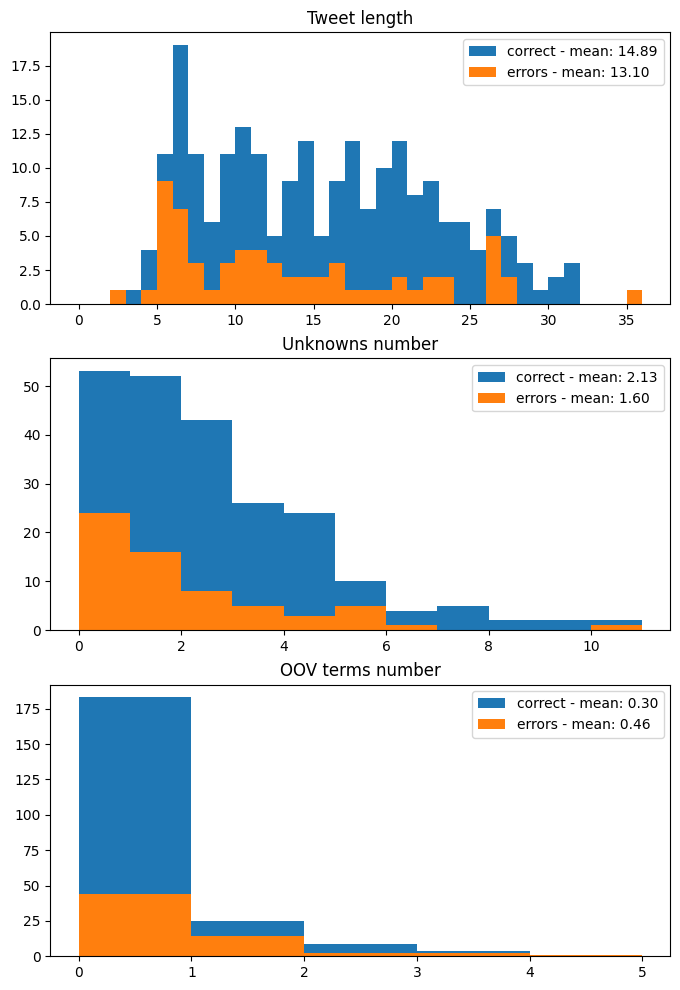

In [67]:
len_correct = df_correct_LSTM.shape[0]
len_errors = df_errors_LSTM.shape[0]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].hist(df_correct_LSTM['tweet_length'], bins=range(max_len_en), label=f'correct - mean: {np.mean(df_correct_LSTM.tweet_length):.2f}')
axes[0].hist(df_errors_LSTM['tweet_length'], bins=range(max_len_en), label=f'errors - mean: {np.mean(df_errors_LSTM.tweet_length):.2f}')
axes[0].set_title('Tweet length')
axes[0].legend()

bin_n = max(len(df_correct_LSTM['unknowns_number'].unique()), len(df_errors_LSTM['unknowns_number'].unique()))
axes[1].hist(df_correct_LSTM['unknowns_number'], bins=range(bin_n), label=f'correct - mean: {np.mean(df_correct_LSTM.unknowns_number):.2f}')
axes[1].hist(df_errors_LSTM['unknowns_number'], bins=range(bin_n), label=f'errors - mean: {np.mean(df_errors_LSTM.unknowns_number):.2f}')
axes[1].set_title('Unknowns number')
axes[1].legend()

bin_n = max(len(df_correct_LSTM['oov_terms_number'].unique()), len(df_errors_LSTM['oov_terms_number'].unique()))
axes[2].hist(df_correct_LSTM['oov_terms_number'], bins=range(bin_n), label=f'correct - mean: {np.mean(df_correct_LSTM.oov_terms_number):.2f}')
axes[2].hist(df_errors_LSTM['oov_terms_number'], bins=range(bin_n), label=f'errors - mean: {np.mean(df_errors_LSTM.oov_terms_number):.2f}')
axes[2].set_title('OOV terms number')
axes[2].legend()

fig.show()

What can be inferred for the LSTM are the following statements:

- **The LSTM classifier appears to handle Unknown and OOV Terms relatively well**, as these factors don't drastically affect the model performances in general. On the other side, **the Tweet Lenght seems to play a bigger role in the differentiation of correct and incorrect predictions.**

- Tweets that are classified correctly tend to have slightly longer average lengths (mean: 14.89) compared to incorrectly classified tweets (mean: 13.10). In addition, looking at the distributions, there are more instances of shorter tweets in the error distribution, suggesting that shorter tweets might be harder for the classifier to handle. <br>
One reason might be that **the model relies on contextual information present in longer tweets for correct predictions, in contrast to shorter ones, which may lack sufficient information, leading to errors**.

In [68]:
df_err_transformer = pd.read_csv("df_test_Transformer.csv", index_col="id_EXIST")
df_err_transformer['tweet_length'] = df_err_transformer['tweet'].apply(lambda x: len(word_tokenize(x)))
df_err_transformer["unknowns_number"] = df_err_transformer['tweet'].apply(lambda x: len([word for word in word_tokenize(x) if word not in word_listing_en]))
df_err_transformer["oov_terms_number"] = df_err_transformer['tweet'].apply(lambda x: len([word for word in word_tokenize(x) if word in oov_terms_glove]))

In [69]:
df_correct_transformer = df_err_transformer[df_err_transformer['hard_labels_task1'] == df_err_transformer['predictions']]
df_errors_transformer = df_err_transformer[df_err_transformer['hard_labels_task1'] != df_err_transformer['predictions']]

In [70]:
df_correct_transformer.describe()

,hard_labels_task1,predictions,tweet_length,unknowns_number,oov_terms_number
count,233.000000,233.000000,233.000000,233.000000,233.000000
mean,0.446352,0.446352,14.931330,2.184549,0.343348
std,0.498184,0.498184,7.270305,2.186424,0.896671
min,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.000000,0.000000,9.000000,1.000000,0.000000
50%,0.000000,0.000000,14.000000,2.000000,0.000000
75%,1.000000,1.000000,21.000000,3.000000,0.000000
max,1.000000,1.000000,31.000000,11.000000,9.000000


In [71]:
df_errors_transformer.describe()

,hard_labels_task1,predictions,tweet_length,unknowns_number,oov_terms_number
count,53.000000,53.000000,53.000000,53.000000,53.000000
mean,0.415094,0.584906,12.566038,1.283019,0.320755
std,0.497454,0.497454,7.412332,1.432821,0.872079
min,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.000000,0.000000,6.000000,0.000000,0.000000
50%,0.000000,1.000000,11.000000,1.000000,0.000000
75%,1.000000,1.000000,17.000000,2.000000,0.000000
max,1.000000,1.000000,35.000000,6.000000,5.000000


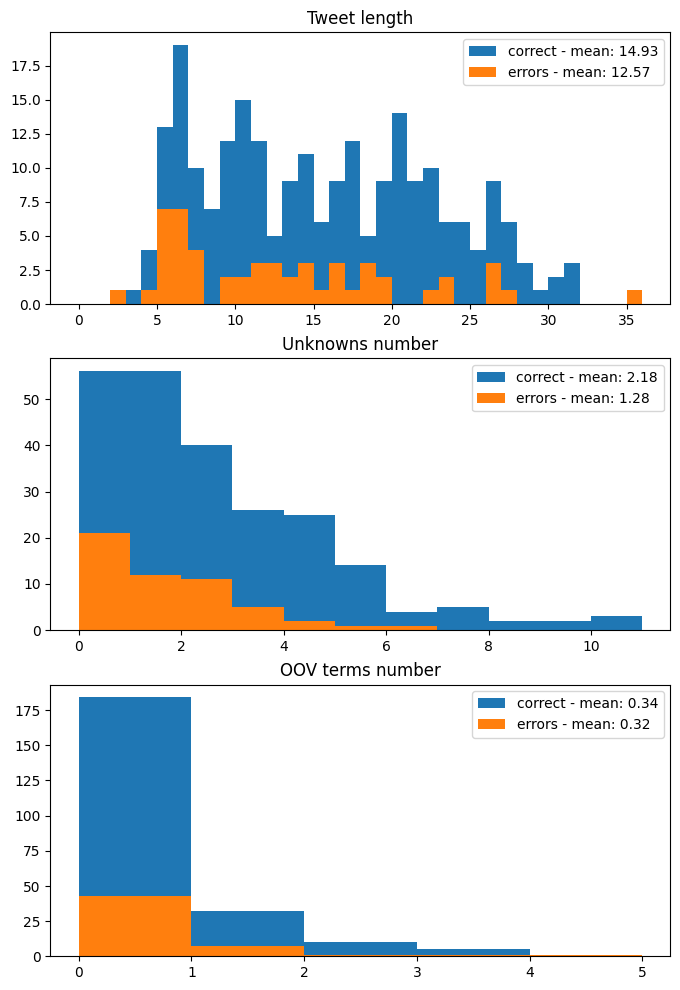

In [72]:
len_correct = df_correct_transformer.shape[0]
len_errors = df_errors_transformer.shape[0]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].hist(df_correct_transformer['tweet_length'], bins=range(max_len_en), label=f'correct - mean: {np.mean(df_correct_transformer.tweet_length):.2f}')
axes[0].hist(df_errors_transformer['tweet_length'], bins=range(max_len_en), label=f'errors - mean: {np.mean(df_errors_transformer.tweet_length):.2f}')
axes[0].set_title('Tweet length')
axes[0].legend()

bin_n = max(len(df_correct_transformer['unknowns_number'].unique()), len(df_errors_transformer['unknowns_number'].unique()))
axes[1].hist(df_correct_transformer['unknowns_number'], bins=range(bin_n), label=f'correct - mean: {np.mean(df_correct_transformer.unknowns_number):.2f}')
axes[1].hist(df_errors_transformer['unknowns_number'], bins=range(bin_n), label=f'errors - mean: {np.mean(df_errors_transformer.unknowns_number):.2f}')
axes[1].set_title('Unknowns number')
axes[1].legend()

bin_n = max(len(df_correct_transformer['oov_terms_number'].unique()), len(df_errors_transformer['oov_terms_number'].unique()))
axes[2].hist(df_correct_transformer['oov_terms_number'], bins=range(bin_n), label=f'correct - mean: {np.mean(df_correct_transformer.oov_terms_number):.2f}')
axes[2].hist(df_errors_transformer['oov_terms_number'], bins=range(bin_n), label=f'errors - mean: {np.mean(df_errors_transformer.oov_terms_number):.2f}')
axes[2].set_title('OOV terms number')
axes[2].legend()

fig.show()

The analysis for the Transformer seems to be quite the same of the LSTM, for a model that suffers from the same problem as before on the shorter tweets. However, the performances are generally better, assessing that **the attention mechanism provides better generalisation properties for all the lenghts**, mitigating the previous problem. It can also be noticed by the fact that even if the f1 score for the Transformer with respect to the LSTM on the validation set is just a bit higher, on the test set the RoBERTa architecture shows a considerable improvement.

## Word Frequency Analysis

The aim this section is to provide a specific view of words occurrences in the tweets. In general, **_Word Frequency Analysis_** is about counting how often each word appears in a given collection of text data in order to identify keywords, common themes and anomalies.

In this case, the analysis is conducted by taking into account the most frequent words in the dataset for all the examples predicted as 1 *(sexist)* and 0 *(not sexist)*. A comparison between the most frequent words in both classes is provided, with a focus on the wrong classified samples, in order to dectect eventual similarities. This has helped to gain more valuable insights on the textual information and structure of the dataset. The objective is to highlight if there is a predominance of words that drives the predictions towards a certain class label, rather than the other.

The same type of analysis has been carried out for both the LSTM and the Transformer, starting with the best performing model, with the following results.

### Transformer

In [73]:
df_err_transformer[df_err_transformer["predictions"] == 1]["tweet"].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
woman,0.038869
like,0.022716
men,0.014639
look,0.012115
get,0.012115
make,0.008077
say,0.008077
man,0.008077
know,0.007572


In [74]:
df_err_transformer[df_err_transformer["predictions"] == 0]["tweet"].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
like,0.006932
amp,0.006932
people,0.006470
get,0.006470
one,0.006470
make,0.005083
would,0.004621
time,0.004621
say,0.004621


In [75]:
df_errors_transformer["tweet"][df_errors_transformer["predictions"] == 1].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
woman,0.023866
men,0.016706
get,0.009547
look,0.009547
penis,0.009547
let,0.009547
man,0.009547
like,0.009547
amp,0.009547


It can be deduced that the words occurrences for the two classes are different. In particular, the words distribution in the tweets classified as _non-sexist_ is quite uniform among all the tokens, as shown by the frequencies. On the other hand, for the _sexist_ samples, there is a predominance of some words, which is reflected also in the false positives predictions.

As a consequence, the main deduction of this analysis is that **the Transformer model tends to classify a tweet as _sexist_ whenever it finds words related to genders like "woman", "men" or like "look", even if they are used in a _non-sexist_ context, showing a sort of bias**.

### LSTM

In [76]:
df_err_LSTM[df_err_LSTM["predictions"] == 1]["tweet"].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
woman,0.042334
like,0.021739
men,0.014302
look,0.013730
get,0.010870
say,0.010297
make,0.010297
know,0.008009
man,0.007437


In [77]:
df_err_LSTM[df_err_LSTM["predictions"] == 0]["tweet"].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
like,0.009178
people,0.008344
get,0.007927
amp,0.006675
one,0.006675
go,0.005006
woman,0.004589
think,0.004589
would,0.004589


In [78]:
df_errors_LSTM[df_errors_LSTM["predictions"] == 1]["tweet"].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
woman,0.026178
time,0.015707
men,0.013089
say,0.010471
call,0.010471
get,0.010471
look,0.010471
1,0.007853
day,0.007853


The same deduction for the Trasformer holds also for the LSTM, with the differnce that in this case **the distribution of the most frequent words is even more similar**.

## Confusion Matrices
Looking at the ***Confusion Matrices***, we can evaluate the performances of our binary classification models to discriminate positive from negative tweets.
What can be inferred by the data below is:

* **True Positives**
  * The LSTM seems to have some troubles in classifying correctly positive tweets. Only the 73% of _sexist_ tweets is identified, with respect to the 83% of the Transformer model.
* **False Positives**
  * As a consequence, the false postives ratio of the LSTM is much higher than the one found for Transformer model, with 27% over 17%. If we suppose that a human supervisor is integrated in the overall system, this kind of misclassification might not be a so big issue.
* **True Negatives**
  * Considering the true negatives, the performance of the models are very similar (82% for the LSTM, 81% for the Transformer). Regardless, identifying a _sexist_ text is more important than misclassifying a _non-sexist_ tweet and these results reflect the data imbalance showed before, even if they are encouraging.
* **False Negatives**
  * As already said, the 18% of false negatives for the LSTM and the 19% for the Transformer are quite good performances. However, not identifying a sexist tweet could be a serious problem, showing the need of some ways to manage the issue and reduce this percentage.
  
In general, the Transformer model seems to be more robust to the class imbalance and the implied biases, as the **False Negative** and **False Positive** percentages are more similar one another. On the other hand, given also the analysis of the word frequencies, the LSTM appears to be more affected by that bias. Further considerations can be done by looking a the **_Precision-Recall Curve_**.

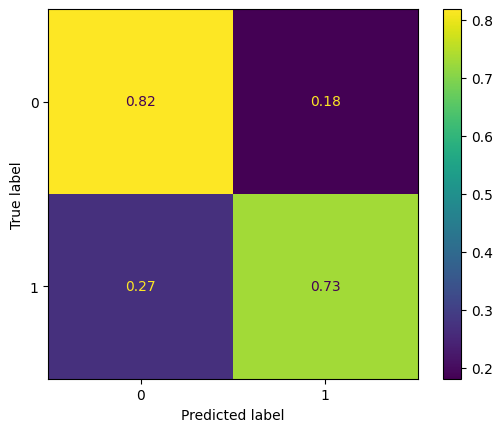

In [79]:
ConfusionMatrixDisplay.from_predictions(df_err_LSTM['hard_labels_task1'].to_list(), df_err_LSTM['predictions'].to_list(), labels=[0,1], normalize="true");

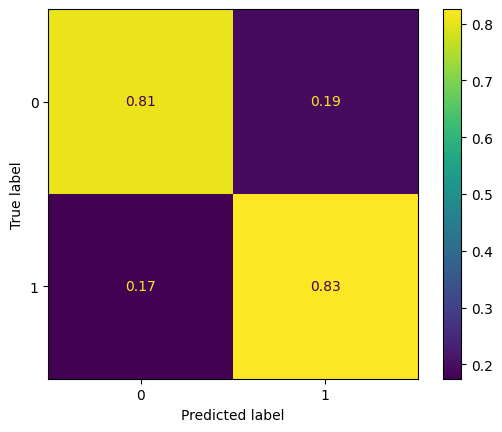

In [80]:
ConfusionMatrixDisplay.from_predictions(df_err_transformer['hard_labels_task1'].to_list(), df_err_transformer['predictions'].to_list(), labels=[0,1], normalize="true");

## Precision-Recall Curves

In order to better understand the performances, strength and witnesses of each model, it is important to analyse the **_Precision-Recall Curves_** of the two models. They provide valuable insights into how the Transformer and LSTM models perform across varying thresholds, especially when balancing **precision** _(accuracy of positive predictions)_ and **recall** _(coverage of true positives)_.

Unlike ***accuracy*** or ***ROC Curves***, the ***Precision-Recall Curves*** avoid overemphasizing true negatives, making them more reliable in scenarios where the positive class is costly to misclassify. Since in our task, misclassifying a _sexist_ tweet as _non-sexist_ one, might be a problem, using this curve is more reasonable.

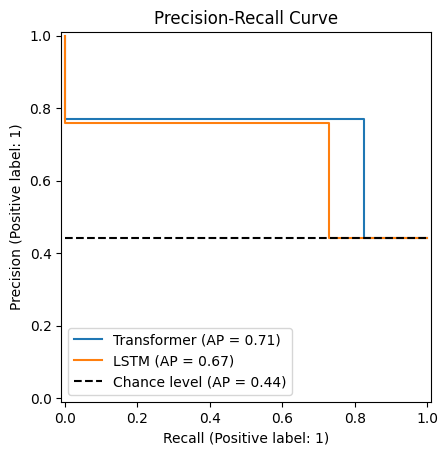

In [81]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(df_err_transformer['hard_labels_task1'], df_err_transformer['predictions'], name="Transformer", ax=ax)
PrecisionRecallDisplay.from_predictions(df_err_LSTM['hard_labels_task1'], df_err_LSTM['predictions'], name="LSTM", ax=ax, plot_chance_level=True)
ax.set_title("Precision-Recall Curve");

### Transformer
The **Transformer** model demonstrates **strong performances with an average precision (AP) of 0.71**, which is higher than the LSTM, as expected. In general, the curve shows that:
- at **_higher thresholds_**, so at _low recall values (left side)_, the Transformer achieves high precision, starting around **0.8**, and maintains this level up to a recall of over **0.8**. It means that, for much of the recall range, the Transformer is able to make accurate predictions.
- at **_lower thresholds_**, as recall increases beyond 0.8 _(right side)_, there is a _steady drop in precision_. It means that where the model predicts more positives to increase recall, it also starts to misclassify more negative samples, introducing false positives.

However, **the Transformer's overall ability to maintain high precision at moderate recall levels makes it a strong choice**. In addition, it maintains better precision across thresholds compared to the LSTM, confirming its superior balance between precision and recall.

### LSTM
The **LSTM** model, having an **average precision (AP) of 0.67**, shows resonably good performances, with a very similar behaviour with respect to the Transformer. In this case, it can be said that:
- at **_higher tresholds_**, its _precision starts quite at the same value of the Transformer_, at around **0.8**, and remains relatively stable up to a recall of **0.7**. However, it is clear that the LSTM consistently **struggles to match the precision-recall balance achieved by the Transformer across all the recall levels**.
- at **_lower tresholds_**, after a recall value of around **0.7**, the behaviour of the LSTM model is the same as the Transformer, reaching the precision levels of a chance predictor.

In general, even if the the LSTM still performs well in certain regions, **its lower recall at lower tresholds suggests that it may be more prone to false negatives compared to the Transformer, as confirmed also by the confusion matrix**. This gap highlights areas where the LSTM could be further optimized, for example, by an appropriate threshold tuning.

## Conclusions and Possible Solutions
What can be evinced from the entire analysis just presented is that the many things are in a way correlated. The _Precision-Recall Curves_ and the _Confusion Matrices_ are referred to the same kind of analysis, as said before. Also the type of information provided is influenced by the _class imbalance_, which is one of the main causes for poor performances in terms of shape of the PR Curve and the AP, especially for the LSTM model.

To address these issues, there could be different solutions, some for the data manipulation and some for model improvements. <br>
Regarding data:

- **rebalancing the training process by applying _class weights_** during the computation of the loss, such to help the model giving equal importance to both classes.

- **data augmentation**, since the dataset size is pretty small, and can be done by gathering new data from other sources or reshuffling the tokenized tweets in actual data, as a pre-processing operation.

- changing the **batch creation strategy** by mixing inputs, such to have always a similar number of data for each lenght range. It can be done by keeping the mean of the tweet lenghts equal or at least similar for all the batches in ach epoch.

- **exploring other pre-processing strategies**, going in the direction of the models with approaches that are more suitable for a specific architecture or similar to the one used in the pre-training (only for imported models).

Regarding the models:

- a way of improving the LSTM is to **increase the number of bidirectional blocks** and add **skip connections** to avoid the vanishing gradient problem.

- for the Transformer, a possibility to get better performances is to **evaluate other models, pre-trained on similar corpora, and exploring other fine-tuning strategies**.

## Spanish Model Analysis
As already said, the evaluation of the models on spanish tweets and its comparison with english ones are done using the corresponding validation sets. In particular, the analysis of the performances is based on two focal points:

- **how data influence the models' behaviour**, as shown in the LSTM trainings on English and Spanish respectively

- **how the choice of the correct model improves performances**, with a focus on a multilingual model against the corresponding monolingual one.

In [82]:
# English predictions on the validation set
df_err_val_LSTM = pd.read_csv("df_val_LSTM.csv", index_col="id_EXIST")
df_err_val_Transformer = pd.read_csv("df_val_Transformer.csv", index_col="id_EXIST")

# Spanish predictions on the validation set
df_err_LSTM_es = pd.read_csv("df_val_LSTM_es.csv", index_col="id_EXIST")
df_err_Transformer_es = pd.read_csv("df_val_Transformer_es.csv", index_col="id_EXIST")

In [83]:
df_train_clean_es['hard_labels_task1'].value_counts(normalize=True)

,proportion
hard_labels_task1,
0,0.511584
1,0.488416


#### English Model vs Spanish Model
As shown by the F1 scores, the Spanish LSTM has poorer performances (**0.78**) with respect to the English one (**0.83**), as expected. The first reason for this behaviour is that **Spanish is morphologically richer than English**, especially on informal data, like tweets in this case, that are subjects to slangs, regional variations, etc. In addition, there are also **cultural differences between languages** for detecting sexist text or hate speech in general and a bigger availability of resources for English outscores Spanish models capabilities.

This behaviour is reflected also in the *Confusion Matrices*, where the English model is far better that Spanish especially in classifying non-sexist tweets. However, Spanish data are more balanced, as the table above exhibit, so also **the True Positives and True Negatives percentages follow the distribution of the training data**.

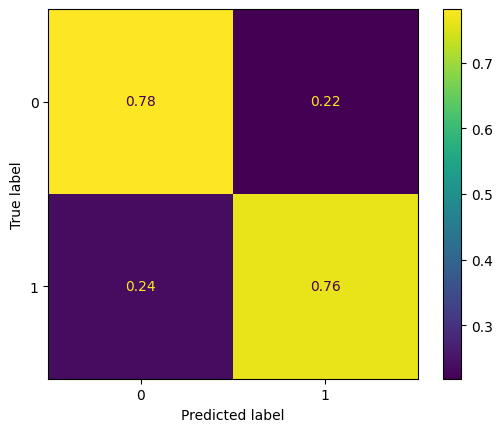

In [84]:
ConfusionMatrixDisplay.from_predictions(df_err_LSTM_es['hard_labels_task1'].to_list(), df_err_LSTM_es['predictions'].to_list(), labels=[0,1], normalize="true");

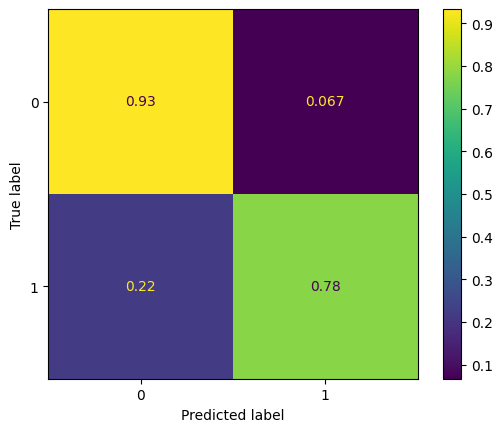

In [85]:
ConfusionMatrixDisplay.from_predictions(df_err_val_LSTM['hard_labels_task1'].to_list(), df_err_val_LSTM['predictions'].to_list(), labels=[0,1], normalize="true");

The disparity in performances is clearly visible also in the *Precision-Recall Curves*. The English model outperforms the Spanish model in precision-recall trade-offs. With an Average Precision (AP) of **0.80**, compared to the Spanish model's **0.74**, the English model demonstrates better precision, especially at higher recall levels. Both models significantly exceed the chance level (**AP = 0.43**). However, even if at lower thresholds the behaviour is slighly better than the English model, **the Spanish one struggles to reach and maintain high enough precision values for most of the recall levels with respect to the other** (0.8 against 0.9 until a recall of almost 0.8).

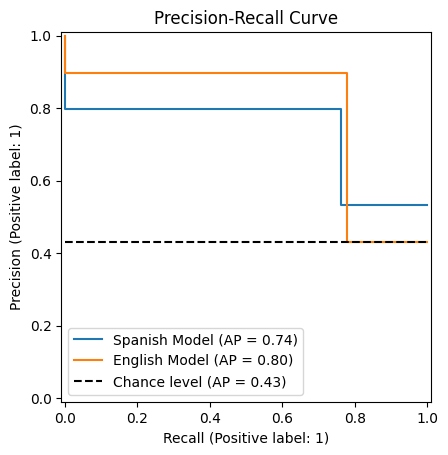

In [86]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(df_err_LSTM_es['hard_labels_task1'], df_err_LSTM_es['predictions'], name="Spanish Model", ax=ax)
PrecisionRecallDisplay.from_predictions(df_err_val_LSTM['hard_labels_task1'], df_err_val_LSTM['predictions'], name="English Model", ax=ax, plot_chance_level=True)
ax.set_title("Precision-Recall Curve");

#### Monolingual Model vs Multilingual Model
The comparison is between a **RoBERTa-based (125M params)** and a **XLM-RoBERTa-based (270M params)** model. The first thing to underline is that, despite the lower number of parameters, **the first model performs considerably better than the second** in terms of pure F1 score, as expected. Also the confusion matrices confirm this statement, with similar percentages of True Positives, but an improvent of almost 10% in the True Negatives.

It means that fine-tuning a multilingual model on a single language is not enough to fill the performance gap with a monolingual one. The reasons could be many, from *vocabulary diluition* to *model capacity*, as XLM-RoBERTa can address 100+ languages, leading to **weaker language-specific representations** and **lower consistency**.

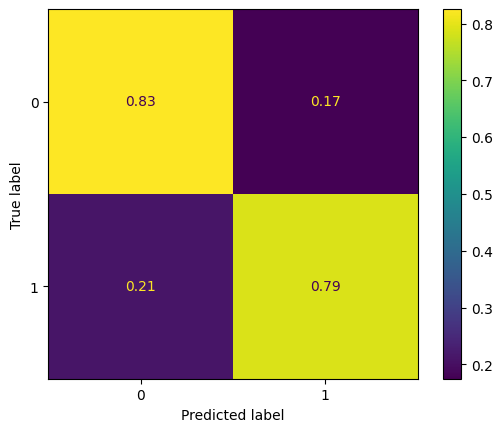

In [87]:
ConfusionMatrixDisplay.from_predictions(df_err_Transformer_es['hard_labels_task1'].to_list(), df_err_Transformer_es['predictions'].to_list(), labels=[0,1], normalize="true");

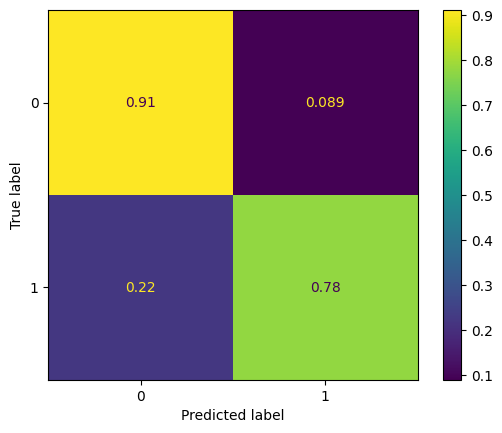

In [88]:
ConfusionMatrixDisplay.from_predictions(df_err_val_Transformer['hard_labels_task1'].to_list(), df_err_val_Transformer['predictions'].to_list(), labels=[0,1], normalize="true");

The Precision-Recall Curves have the same average precision (AP), even if the models behave differently:

- at **higher and medium thresholds** they have similar precision values, with the monolingual model that is slightly better, reaching almost *0.9*
- at **lower thresholds** the situation is completely the opposite, with the multilingual model that maintains reasonable values of precision, while the monolingual one drops to the chance level.

However, if we broad up the scope to overall evaluations, **the monolingual model maintains better precision over most of the recall levels** and appears as smoother. This observations reflect the comparison on the F1 scores, confirming the previous thesis that **a multilingual model is not able to reach monolingual performances on single-language tasks**.

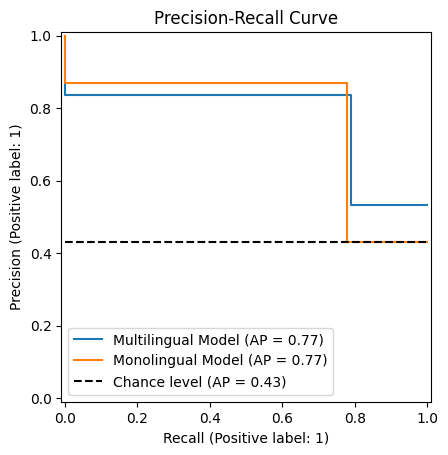

In [89]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(df_err_Transformer_es['hard_labels_task1'], df_err_Transformer_es['predictions'], name="Multilingual Model", ax=ax)
PrecisionRecallDisplay.from_predictions(df_err_val_Transformer['hard_labels_task1'], df_err_val_Transformer['predictions'], name="Monolingual Model", ax=ax, plot_chance_level=True)
ax.set_title("Precision-Recall Curve");

# [Task 8 - 0.5 points] Report



Wrap up your experiment in a short report (up to 2 pages).

### Instructions



* Use the NLP course report template.

* Summarize each task in the report following the provided template.

### Recommendations



The report is not a copy-paste of graphs, tables, and command outputs.



* Summarize classification performance in Table format.

* **Do not** report command outputs or screenshots.

* Report learning curves in Figure format.

* The error analysis section should summarize your findings.


# Submission



* **Submit** your report in PDF format.

* **Submit** your python notebook.

* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ



Please check this frequently asked questions before contacting us

### Execution Order



You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings



You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture



You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.


### Neural Libraries



You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer



If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation



Each model is trained with at least 3 random seeds.



Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis



To carry out the error analysis you are **free** to either



* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)

* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis



Some topics for discussion include:

   * Precision/Recall curves.

   * Confusion matrices.

   * Specific misclassified samples.

### Bonus Points

Bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis

- Masterclass code organization

- Suitable extensions

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).



**Possible Extensions/Explorations for Bonus Points:**

- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.

- **Experiment with other custom architectures or models from HuggingFace**

- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.












# The End